In [7]:
import json
import os
import sys
par_dir = os.path.dirname(os.path.realpath("."))
sys.path.append(os.path.join(par_dir))
import pickle
from matplotlib import pyplot as plt
from utils import get_transferability, get_transferability_for_baseline, plot_sparsify_contrast_baseline, get_inds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline


In [8]:
def plot_generalization(thress, disjoint_and, joint_and, disjoint_or, joint_or, baseline = None, title = None, get_legend = False, xticks = range(50, 500, 100), verbose = False):

    plt.figure()
    aw = 3
    fs = 20
    width = 3
    # plt.tick_params(axis='both', which='major', width=3.5, length=10)
    plt.rc('axes', linewidth=aw)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.rcParams['xtick.major.width'] = aw
    plt.rcParams['ytick.major.width'] = aw
    plt.rcParams['xtick.major.size'] = 7
    plt.rcParams['ytick.major.size'] = 7
    plt.rcParams['font.size'] = fs
    ax = plt.gca()

    plt.rcParams['font.size'] = fs
    plt.rcParams['xtick.labelsize'] = fs
    plt.rcParams['ytick.labelsize'] = fs
    plt.xticks(xticks)
    plt.xlabel("# of salient interactions",fontdict={'fontsize': 25})
    
    plt.plot(thress, disjoint_and, label='And interaction (traditional)', color='#3A87BC', linestyle='--',marker='o',linewidth=width)
    plt.plot(thress, joint_and, label='And interaction (ours)', color='#3A87BC',marker='o',linewidth=width)
    
    if verbose:
        for i, txt in enumerate(disjoint_and):
            plt.annotate(np.around(txt,2), (thress[i], disjoint_and[i]))
        for i, txt in enumerate(joint_and):
            plt.annotate(np.around(txt,2), (thress[i], joint_and[i]))

    
    if baseline:
        plt.plot(thress, baseline, label='And interaction (baseline)', color='green', linestyle='--',marker='o',linewidth=width)
    plt.plot(thress, disjoint_or, label='Or interaction (traditional)', color="#FF9230", linestyle='--',marker='o',linewidth=width)
    plt.plot(thress, joint_or, label='Or interaction (ours)', color="#FF9230",marker='o',linewidth=width)

    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    for tick in plt.gca().xaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    for tick in plt.gca().yaxis.get_major_ticks():
        tick.label1.set_fontweight('bold')
    
    if title:
        plt.title(title, pad=20, fontdict={'fontsize': 25})


    plt.show()
    
    if get_legend:
        figsize = (10, 10)
        fig_leg = plt.figure(figsize=figsize)
        ax_leg = fig_leg.add_subplot(111)
        # add the legend from the previous axes
        ax_leg.legend(*ax.get_legend_handles_labels(), loc='center')
        # hide the axes frame and the x/y labels
        ax_leg.axis('off')
        plt.show()
        plt.close()
    plt.close()

## BERT-Base VS. BERT-Large on SST2

In [9]:
# Constants

data_path = json.load(open('outputPaths_sst2.json', 'r'))
bert_base_disjoint_path = data_path['disjoint']['bert-base']
bert_large_disjoint_path = data_path['disjoint']['bert-large']
print(data_path)
joint_path = data_path['joint']

baseline_base = data_path['baseline_base']
baseline_large = data_path['baseline_large']


inds = get_inds(joint_path)

labels = ['ours', 'traditional method']

log = False
alphas = [0.0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

thress = np.arange(0.05, 0.5, 0.05)
interaction_num = 1024

{'disjoint': {'bert-base': '/data1/cl/generalizable-interaction/output/task1/traditional/base', 'bert-large': '/data1/cl/generalizable-interaction/output/task1/traditional/large'}, 'joint': '/data1/cl/generalizable-interaction/output/task1/generalizable', 'baseline_base': '/data1/cl/distillation/output/base/2023-11-14-19-59-58_q_tricks_False/PAD', 'baseline_large': '/data1/cl/distillation/output/large/2023-11-14-20-23-56_q_tricks_False/PAD'}


In [10]:
disjoint_and = []
disjoint_or = []

joint_and = []
joint_or = []

baseline_and = []


for thres in thress:
    salient_fixed_num = int(interaction_num * thres)  # fix the number of salient interaction by thres
    print("num of salient interaction:", salient_fixed_num)

    # add an 'output_path' to 'get_transferability_for_baseline' to save the results to local (.csv)
    df_joint = get_transferability_for_baseline(data_path=joint_path, inds=inds, salient_fixed_num=salient_fixed_num,
                                   string=f"baseline_joint_{thres}.csv",
                                   add_or=True)

    df_disjoint = get_transferability_for_baseline(data_path=(bert_base_disjoint_path, bert_large_disjoint_path), inds=inds,
                                      salient_fixed_num=salient_fixed_num, string= f"baseline_disjoint_{thres}.csv", add_or=True)

    df_baseline = get_transferability_for_baseline(data_path=(baseline_base, baseline_large), inds=inds,
                                        salient_fixed_num=salient_fixed_num, string=f"baseline_baseline_disjoint_{thres}.csv", add_or=False, prefix = True) 
    
    disjoint_and.append(df_disjoint['And percent'].mean())
    disjoint_or.append(df_disjoint['Or percent'].mean())
    joint_and.append(df_joint['And percent'].mean())
    joint_or.append(df_joint['Or percent'].mean())
    baseline_and.append(df_baseline['And percent'].mean())

disjoint_and_max_thres = thress[np.argsort(disjoint_and)[-1]]
disjoint_or_max_thres = thress[np.argsort(disjoint_or)[-1]]

joint_and_max_thres = thress[np.argsort(joint_and)[-1]]
joint_or_max_thres = thress[np.argsort(joint_or)[-1]]

print(f"disjoint_and_max_thres:{disjoint_and_max_thres}")
print(f"joint_and_max_thres:{joint_and_max_thres}")

num of salient interaction: 51


ind: 100%|██████████| 200/200 [00:00<00:00, 361.41it/s]


num of salient interaction: 102


ind: 100%|██████████| 200/200 [00:00<00:00, 352.09it/s]


num of salient interaction: 153


ind: 100%|██████████| 200/200 [00:00<00:00, 313.67it/s]


num of salient interaction: 204


ind: 100%|██████████| 200/200 [00:00<00:00, 333.89it/s]


num of salient interaction: 256


ind: 100%|██████████| 200/200 [00:00<00:00, 306.25it/s]


num of salient interaction: 307


ind: 100%|██████████| 200/200 [00:00<00:00, 294.80it/s]


num of salient interaction: 358


ind: 100%|██████████| 200/200 [00:00<00:00, 319.32it/s]


num of salient interaction: 409


ind: 100%|██████████| 200/200 [00:00<00:00, 291.48it/s]


num of salient interaction: 460


ind: 100%|██████████| 200/200 [00:00<00:00, 288.92it/s]

disjoint_and_max_thres:0.45
joint_and_max_thres:0.45


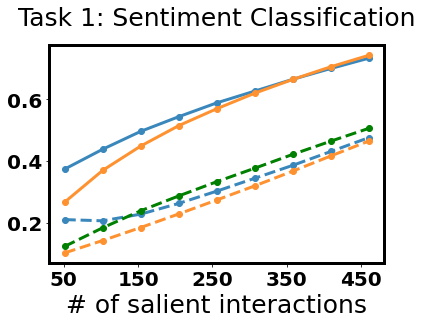

In [11]:
plot_generalization(interaction_num * thress, disjoint_and, joint_and, disjoint_or, joint_or, baseline_and, "Task 1: Sentiment Classification")

## LlaMa VS. OPT-1.3B on SQuAD

In [12]:
model_names = ['llama', 'opt']  # 模型名称
model_name_print = ['LLaMA', 'OPT-1.3B']
data_path = json.load(open('outputPaths_squad.json', 'r'))


DataPaths = {
    'llama': data_path["disjoint"]["llama"],
    'opt': data_path["disjoint"]["opt"],
    'joint_llama_opt_05': data_path["joint"]
}  

joint_path = data_path['joint']
llama_disjoint_path = data_path['disjoint']['llama']
opt_disjoint_path = data_path['disjoint']['opt']
inds = get_inds(joint_path, dataset="squad")
inds.sort()
inds = inds[:200]


In [13]:
epsilon = '05'  
num_players = 10 
interaction_num  = 1024
thress = np.arange(0.05,0.5,0.05)

disjoint_and = []
disjoint_or = []
joint_and = []
joint_or = []

for thres in thress:
    salient_fixed_num = int(interaction_num * thres)  # 设置固定的显著交互个数，为交互个数的0.1倍
    print("num of salient interaction:", salient_fixed_num)

    string = f"joint_{thres}.csv"
    df_joint = get_transferability(data_path=joint_path, inds=inds, salient_fixed_num=salient_fixed_num, string=string, output_path=None, dataset = "squad", model_name=model_names)

    string = f"disjoint_{thres}.csv"
    df_disjoint = get_transferability(data_path=(llama_disjoint_path, opt_disjoint_path), inds=inds,
                        salient_fixed_num=salient_fixed_num, string=string, output_path=None, dataset = "squad", model_name=model_names)

    disjoint_and.append(df_disjoint['And percent'].mean())
    disjoint_or.append(df_disjoint['Or percent'].mean())
    joint_and.append(df_joint['And percent'].mean())
    joint_or.append(df_joint['Or percent'].mean())

disjoint_and_max_thres = thress[np.argsort(disjoint_and)[-1]]
disjoint_or_max_thres = thress[np.argsort(disjoint_or)[-1]]
joint_and_max_thres = thress[np.argsort(joint_and)[-1]]
joint_or_max_thres = thress[np.argsort(joint_or)[-1]]

print(f"disjoint_and_max_thres:{disjoint_and_max_thres}")
print(f"disjoint_or_max_thres:{disjoint_or_max_thres}")
print(f"joint_and_max_thres:{joint_and_max_thres}")
print(f"joint_or_max_thres:{joint_or_max_thres}")

num of salient interaction: 51


ind: 100%|██████████| 200/200 [00:00<00:00, 268.37it/s]


num of salient interaction: 102


ind: 100%|██████████| 200/200 [00:00<00:00, 268.74it/s]


num of salient interaction: 153


ind: 100%|██████████| 200/200 [00:00<00:00, 263.05it/s]


num of salient interaction: 204


ind: 100%|██████████| 200/200 [00:00<00:00, 248.61it/s]


num of salient interaction: 256


ind: 100%|██████████| 200/200 [00:00<00:00, 245.30it/s]


num of salient interaction: 307


ind: 100%|██████████| 200/200 [00:00<00:00, 259.54it/s]


num of salient interaction: 358


ind: 100%|██████████| 200/200 [00:00<00:00, 238.90it/s]


num of salient interaction: 409


ind: 100%|██████████| 200/200 [00:00<00:00, 231.25it/s]


num of salient interaction: 460


ind: 100%|██████████| 200/200 [00:00<00:00, 257.10it/s]

disjoint_and_max_thres:0.45
disjoint_or_max_thres:0.45
joint_and_max_thres:0.45
joint_or_max_thres:0.45


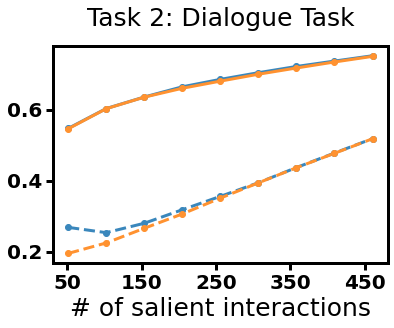

In [14]:
plot_generalization(interaction_num * thress, disjoint_and, joint_and, disjoint_or, joint_or, baseline=None, title = "Task 2: Dialogue Task", xticks =range(50,500,100))

## Resnet-20 VS. VGG-16 on MNIST

In [15]:
# path
data_path = json.load(open('outputPaths_mnist.json', 'r'))
bert_joint_path = data_path['joint']
bert_base_disjoint_path = data_path['disjoint']['resnet20']  # ['bert-base']
bert_large_disjoint_path = data_path['disjoint']['vgg16']  # ['bert-large']

# inds
bert_base_disjoint = get_inds(data_path['disjoint']['resnet20'], "mnist") 
bert_large_disjoint = get_inds(data_path['disjoint']['vgg16'], "mnist") 
bert_joint = get_inds(data_path['joint'], "mnist")[:100]  

inds = bert_joint
interaction_num = 256  # 2^8
labels = ['ours', 'traditional method']

log = False

### hbh
thress = np.arange(0.05, 0.5, 0.05)
disjoint_and = []
disjoint_or = []
joint_and = []
joint_or = []
for thres in thress:
    salient_fixed_num = int(interaction_num * thres)  # 设置固定的显著交互个数，为交互个数的0.1倍
    print("num of salient interaction:", salient_fixed_num)

    string = f"joint_{thres}.csv"
    df_joint = get_transferability(data_path=bert_joint_path, inds=inds, salient_fixed_num=salient_fixed_num,
                                   string=string,
                                   output_path=None, dataset="mnist")

    string = f"disjoint_{thres}.csv"
    df_disjoint = get_transferability(data_path=(bert_base_disjoint_path, bert_large_disjoint_path), inds=inds,
                                      salient_fixed_num=salient_fixed_num, string=string, output_path=None, dataset="mnist")

    disjoint_and.append(df_disjoint['And percent'].mean())
    disjoint_or.append(df_disjoint['Or percent'].mean())
    joint_and.append(df_joint['And percent'].mean())
    joint_or.append(df_joint['Or percent'].mean())

disjoint_and_max_thres = thress[np.argsort(disjoint_and)[-1]]
disjoint_or_max_thres = thress[np.argsort(disjoint_or)[-1]]
joint_and_max_thres = thress[np.argsort(joint_and)[-1]]
joint_or_max_thres = thress[np.argsort(joint_or)[-1]]

print(f"disjoint_and_max_thres:{disjoint_and_max_thres}")
print(f"disjoint_or_max_thres:{disjoint_or_max_thres}")
print(f"joint_and_max_thres:{joint_and_max_thres}")
print(f"joint_or_max_thres:{joint_or_max_thres}")


num of salient interaction: 12


ind: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]


num of salient interaction: 25


ind: 100%|██████████| 100/100 [00:00<00:00, 282.29it/s]


num of salient interaction: 38


ind: 100%|██████████| 100/100 [00:00<00:00, 269.14it/s]


num of salient interaction: 51


ind: 100%|██████████| 100/100 [00:00<00:00, 240.35it/s]


num of salient interaction: 64


ind: 100%|██████████| 100/100 [00:00<00:00, 237.57it/s]


num of salient interaction: 76


ind: 100%|██████████| 100/100 [00:00<00:00, 243.66it/s]


num of salient interaction: 89


ind: 100%|██████████| 100/100 [00:00<00:00, 239.93it/s]


num of salient interaction: 102


ind: 100%|██████████| 100/100 [00:00<00:00, 246.26it/s]


num of salient interaction: 115


ind: 100%|██████████| 100/100 [00:00<00:00, 248.34it/s]


disjoint_and_max_thres:0.05
disjoint_or_max_thres:0.45
joint_and_max_thres:0.35000000000000003
joint_or_max_thres:0.45


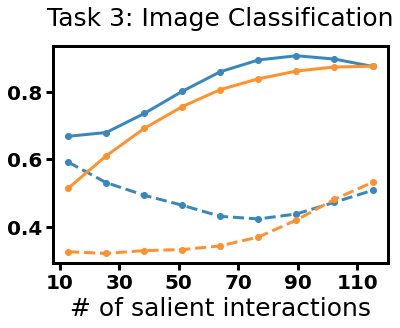

In [16]:
plot_generalization(interaction_num * thress, disjoint_and, joint_and, disjoint_or, joint_or, baseline=None, title = "Task 3: Image Classification", xticks = range(10,130,20))